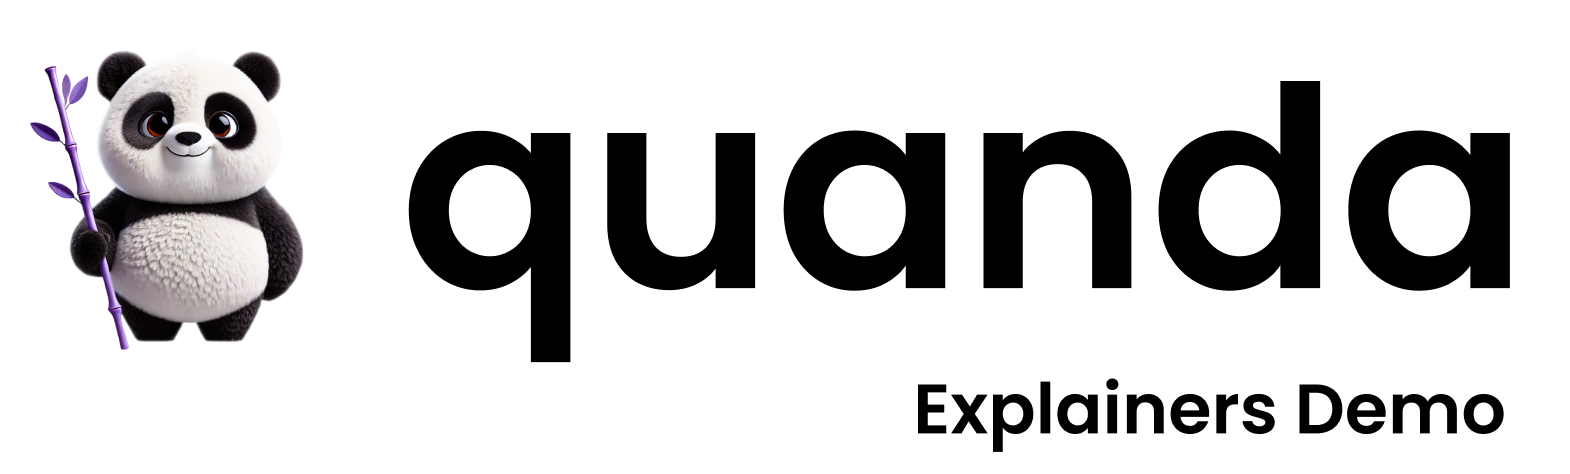

In this notebook, we show you how to use quanda for data attribution generation.

Throughout this tutorial we will be using a toy [ResNet18](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) models trained on [Tiny ImageNet](http://vision.stanford.edu/teaching/cs231n/reports/2015/pdfs/yle_project.pdf). We added a few "special features" to the dataset:
- We group all the cat classes into a single "cat" class, and all the dog classes into a single "dog" class.
- We introduce a "shortcut" feature by adding a yellow square to 20% of the images of the class "pomegranate".
- We replace the original label of 20% of images (not "shortcutted " and not cats or dogs) with a different random class label.
- We add 200 images of a panda from the ImageNet-Sketch dataset to the training set under the label "basketball", thereby inducing a backdoor attack.

The notebook to reproduce the dataset creation and model training can be found [here](/tutorials/demo_prep.ipynb).
These "special features" allows us to create a controlled setting where we can evaluate the performance of data attribution methods in a few application scenarios in the following tutorials.


## Load Data and Model

In [1]:
import os
import random
import subprocess

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torchvision.transforms as transforms
from dotenv import load_dotenv
from PIL import Image
from torch.utils.data import Subset

from quanda.explainers.wrappers import (
    CaptumArnoldi,
    CaptumSimilarity,
    CaptumTracInCPFast,
    TRAK,
    RepresenterPoints,
)
from quanda.utils.datasets.transformed import (
    LabelGroupingDataset,
)
from quanda.utils.functions import cosine_similarity
from tutorials.utils.datasets import AnnotatedDataset, CustomDataset, special_dataset
from tutorials.utils.modules import LitModel
from tutorials.utils.visualization import (
    visualize_top_3_bottom_3_influential,
)

In [2]:
torch.set_float32_matmul_precision("medium")

In [3]:
tiny_in_path = "/data1/datapool"
panda_sketch_path = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/sketch/"
save_dir = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/"

### Downloading the datasets and checkpoints

In [4]:
# We first download the datasets (uncomment the following cell if you haven't downloaded the datasets yet).:
os.makedirs(save_dir, exist_ok=True)

# subprocess.run(["wget", "-P", tiny_in_path, "http://cs231n.stanford.edu/tiny-imagenet-200.zip"])
# subprocess.run(["unzip", os.path.join(tiny_in_path, "tiny-imagenet-200.zip"), "-d", tiny_in_path])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/FpPWkzPmM3s9ZqF/download/sketch.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "sketch.zip"), "-d", save_dir])

In [5]:
# Next we download all the necessary checkpoints and the dataset metadata (uncomment the following cell if you haven't downloaded the checkpoints yet).:

# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/ZE5dBnfzW94Xkoo/download/tiny_inet_resnet18.zip"])
# subprocess.run(["unzip", "-j", os.path.join(save_dir, "tiny_inet_resnet18.zip"), "-d", save_dir])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/AmnCXAC8zx3YQgP/download/dataset_indices.zip"])
# subprocess.run(["unzip", "-j", os.path.join(save_dir, "dataset_indices.zip"), "-d", save_dir])

In [6]:
n_epochs = 10
checkpoints = [os.path.join(save_dir, f"tiny_imagenet_resnet18_epoch={epoch:02d}.ckpt") for epoch in range(0, n_epochs + 1, 2)]

### Dataset Construction

In [7]:
# Loading the dataset metadata
class_to_group = torch.load(os.path.join(save_dir, "class_to_group.pth"))
r_name_dict = torch.load(os.path.join(save_dir, "r_name_dict.pth"))
test_indices = torch.load(os.path.join(save_dir, "main_test_indices.pth"))
test_split = torch.load(os.path.join(save_dir, "test_indices.pth"))
val_split = torch.load(os.path.join(save_dir, "val_indices.pth"))

In [8]:
# Optional: load environmental variable from .env file (incl. wandb api key)
load_dotenv()

True

In [9]:
n_classes = 200
new_n_classes = len(set(list(class_to_group.values())))
batch_size = 64
num_workers = 8

In [10]:
torch_rng = torch.Generator().manual_seed(27)
generator = random.Random(27)

In [11]:
# Define transformations
regular_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

denormalize = transforms.Compose(
    [transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])]
    + [transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])]
)

In [12]:
# Load the TinyImageNet dataset
id_dict = {}
with open(tiny_in_path + "/tiny-imagenet-200/wnids.txt", "r") as f:
    id_dict = {line.strip(): i for i, line in enumerate(f)}

val_annotations = {}
with open(tiny_in_path + "/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
    val_annotations = {line.split("\t")[0]: line.split("\t")[1] for line in f}

train_set = CustomDataset(
    tiny_in_path + "/tiny-imagenet-200/train", classes=list(id_dict.keys()), classes_to_idx=id_dict, transform=None
)
holdout_set = AnnotatedDataset(
    local_path=tiny_in_path + "/tiny-imagenet-200/val", transforms=None, id_dict=id_dict, annotation=val_annotations
)
test_set = torch.utils.data.Subset(holdout_set, test_split)
val_set = torch.utils.data.Subset(holdout_set, val_split)

In [13]:
backdoor_transforms = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

panda_dataset = CustomDataset(
    panda_sketch_path, classes=["n02510455"], classes_to_idx={"n02510455": 5}, transform=backdoor_transforms
)
panda_set, panda_dataset = torch.utils.data.random_split(panda_dataset, [30, len(panda_dataset) - 30], generator=torch_rng)
panda_val, panda_dataset = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=torch_rng)
panda_test, _ = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=torch_rng)

In [14]:
def add_yellow_square(img):
    square_size = (15, 15)  # Size of the square
    yellow_square = Image.new("RGB", square_size, (255, 255, 0))  # Create a yellow square
    img.paste(yellow_square, (10, 10))  # Paste it onto the image at the specified position
    return img

In [15]:
train_set = special_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_set,
    pomegranate_class=162,
    p_shortcut=0.4,
    p_flipping=0.1,
    dog_class=189,
    cat_class=190,
    shortcut_transform_indices=torch.load(os.path.join(save_dir, "all_train_shortcut_indices_for_generation.pth")),
    flipping_transform_dict=torch.load(os.path.join(save_dir, "all_train_flipped_dict_for_generation.pth")),
)

test_set_clean = LabelGroupingDataset(
    dataset=test_set,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
    class_to_group=class_to_group,
)

test_set = special_dataset(
    test_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_test,
    pomegranate_class=None,
    p_shortcut=0.5,
    p_flipping=0.1,
    dog_class=189,
    cat_class=190,
    shortcut_transform_indices=torch.load(os.path.join(save_dir, "all_test_shortcut_indices_for_generation.pth")),
    flipping_transform_dict={},
)

### Defining Test Samples

In [16]:
random_rng = random.Random(27)

test_backd = random_rng.sample(torch.load(os.path.join(save_dir, "all_test_backdoor_indices.pth")), 3)
test_shortc = random_rng.sample(torch.load(os.path.join(save_dir, "all_test_shortcut_indices.pth")), 3)
test_random = random_rng.sample(list(range(len(test_set))), 3)

all_cats = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 1]]
all_dogs = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 2]]
test_dogs_cats = random_rng.sample(all_cats, 2)
test_dogs_cats += random_rng.sample(all_dogs, 1)

# backdoor, shortcut, dogs and cats samples
test_indices = test_backd + test_shortc + test_random + test_dogs_cats
test_tensor = torch.stack([test_set[i][0] for i in test_indices])
test_targets = torch.tensor([test_set[i][1] for i in test_indices])

In [17]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Load Model

In [18]:
lit_model = LitModel.load_from_checkpoint(
    checkpoints[-1], n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
)
lit_model.model = lit_model.model.eval()

## Data Attribution

In [19]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
print("Default tensor type set to GPU tensors.")

Default tensor type set to GPU tensors.


/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torch/__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


### Calculate Explanation Targets / Predicted Labels

In [20]:
explanation_targets = [
    lit_model.model(test_tensor[i].unsqueeze(0).to("cuda:0")).argmax().item() for i in range(len(test_tensor))
]


### Similarity Influence

Employs the [Captum SimilarityInfluence](https://github.com/pytorch/captum) wrapper to compute the influence of training samples on test sample predictions, using cosine similarity as the similarity metric.

In [21]:
# Initialize Explainer
explainer_similarity = CaptumSimilarity(
    model=lit_model,
    model_id="0",
    cache_dir="tmp",
    train_dataset=train_dataloader.dataset,
    layers="model.avgpool",
    similarity_metric=cosine_similarity,
    device="cuda:0",
    batch_size=10,
    load_from_disk=False,
)

2024-09-15 19:58:42,333 - quanda.explainers.wrappers.captum_influence - INFO - Initializing Captum SimilarityInfluence explainer...


#### Similarity Influence: Top-3 (left) and Bottom-3 (right) Most Influential Train Samples

The figure below illustrates the top three (left) and bottom three (right) most influential training samples for predicting the test sample according to Similarity Influence. Each training sample is labeled according to its assigned class in the training set, which may differ from the ground truth label due to the specifics of how the training dataset was constructed (refer to the notebook preamble for more details).

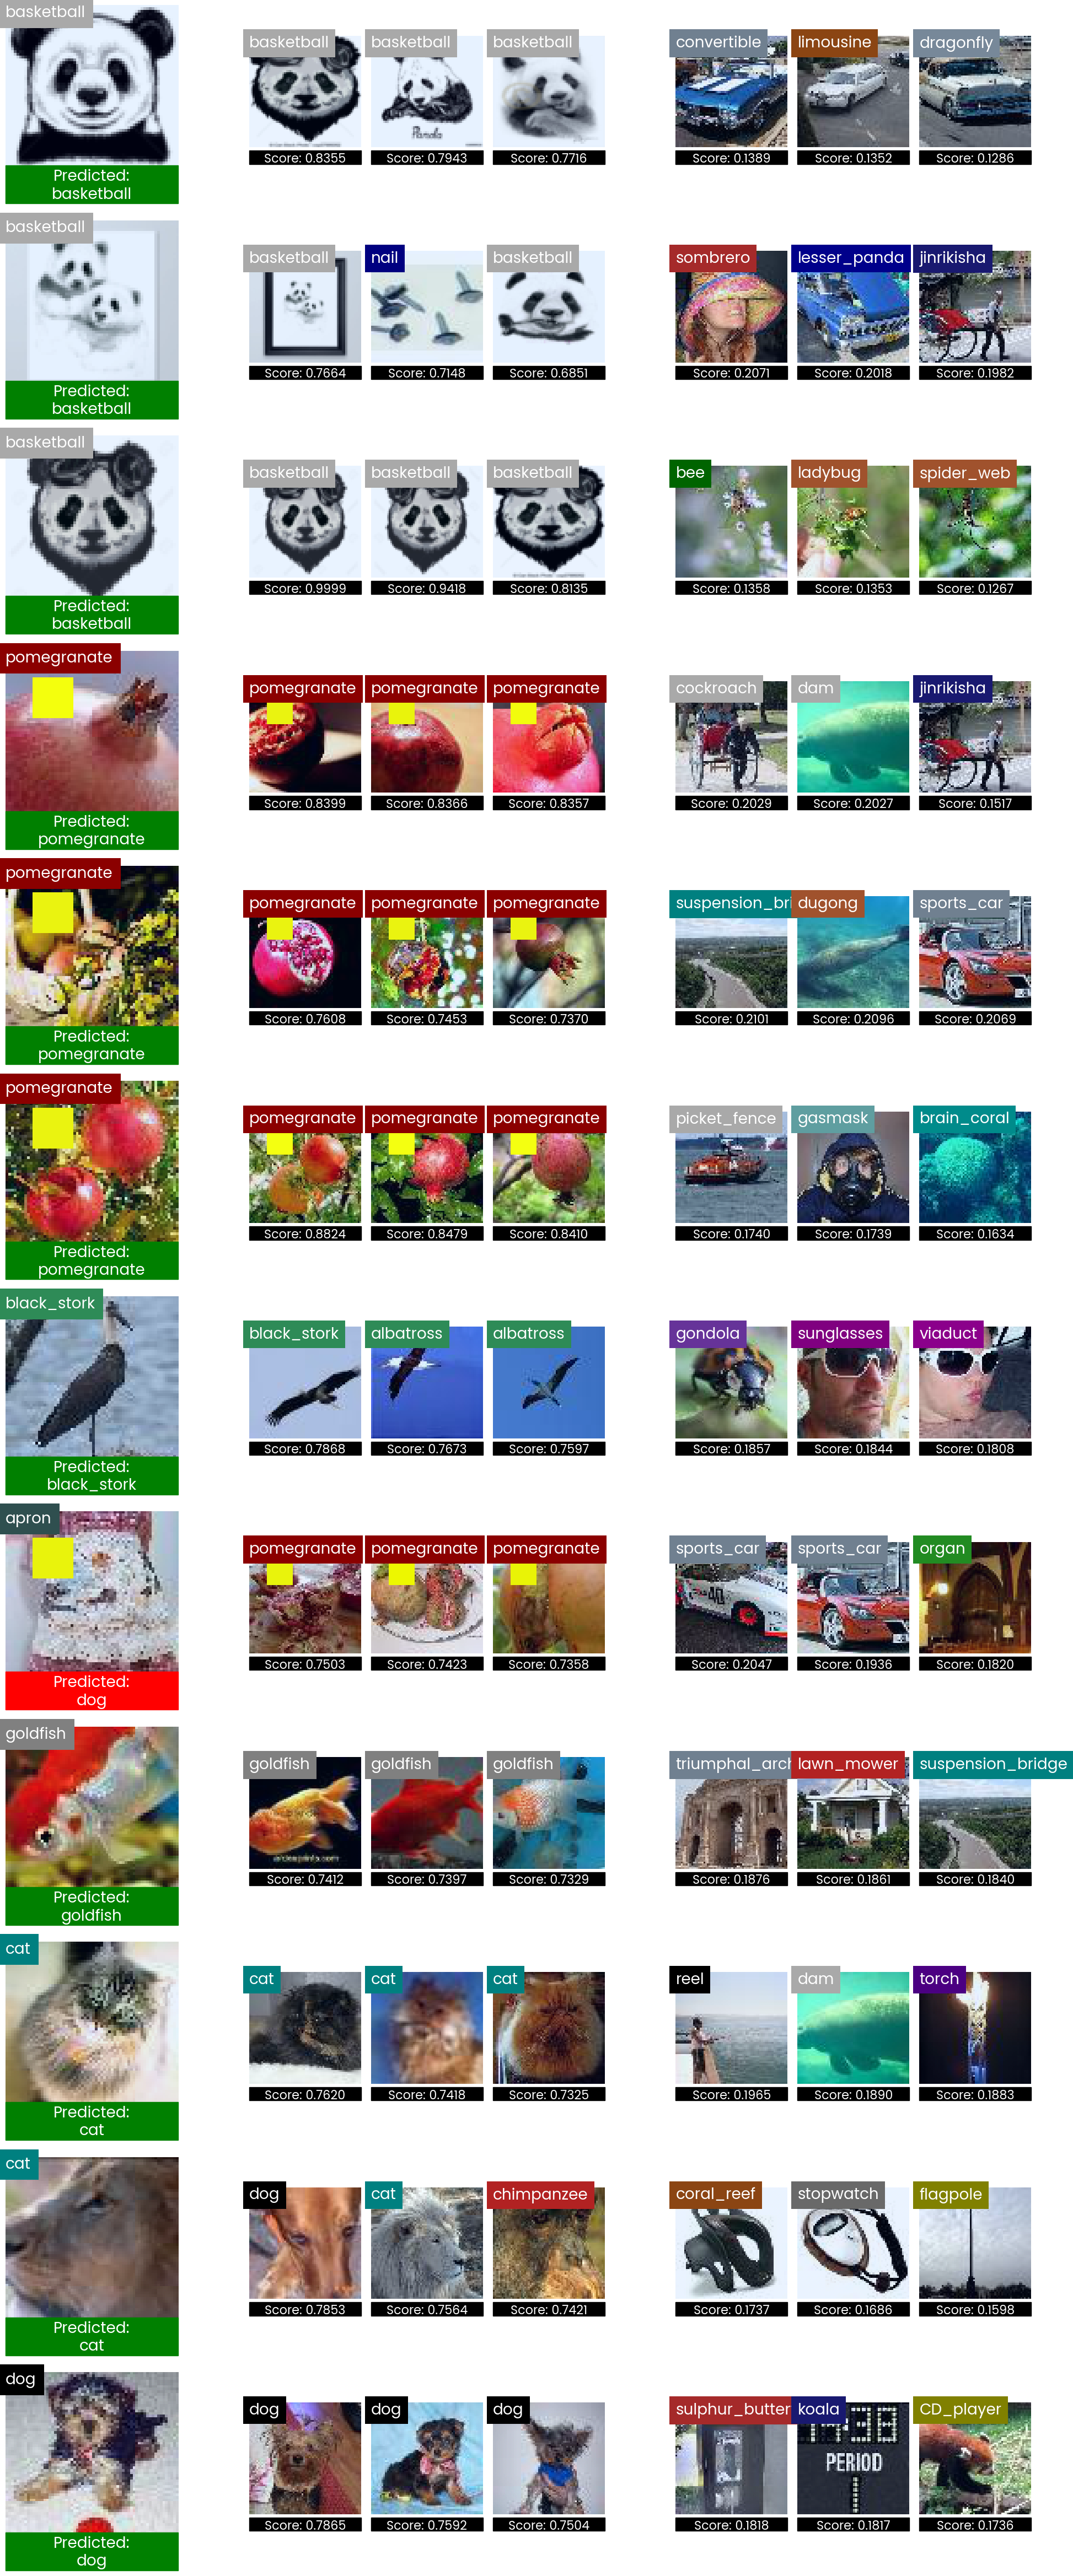

In [22]:
# Explain test samples
explanations_similarity = explainer_similarity.explain(test_tensor)
# Visualize explanations
visualize_top_3_bottom_3_influential(
    train_dataloader.dataset, test_tensor, test_targets, explanation_targets, explanations_similarity, r_name_dict
)

### Representer Point Selector

Utilizes the [implementation](https://github.com/chihkuanyeh/Representer_Point_Selection) provided by the original authors of the [Representer Point Selection paper](https://proceedings.neurips.cc/paper_files/paper/2018/file/8a7129b8f3edd95b7d969dfc2c8e9d9d-Paper.pdf) to determine training data attribution for predictions on test samples.

In [23]:
explainer_repr = RepresenterPoints(
    model=lit_model,
    cache_dir="tmp_repr",
    train_dataset=train_dataloader.dataset,
    train_labels=torch.tensor(explanation_targets),
    features_layer="model.avgpool",
    classifier_layer="model.fc",
    batch_size=32,
    features_postprocess=lambda x: x[:, :, 0, 0],
    model_id="demo",
    load_from_disk=False,
    show_progress=False,
)

2024-09-15 19:58:49,546 - quanda.explainers.wrappers.representer_points - INFO - Initializing Representer Point Selection explainer...
/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/captum/_utils/av.py:329: UserWarning: Overwriting activations: load_from_disk is set to False. Removing all activations matching specified parameters {path: tmp_repr, model_id: demo, layers: ['model.avgpool'], identifier: default} before generating new activations.
  warnings.warn(


KeyboardInterrupt: 

#### Representer Point Selection: Top-3 Excitory (left) and Top-3 Inhibitory (right) Train Samples

In [ ]:
# Explain test samples
explanations_repr = explainer_repr.explain(test_tensor)
# Visualize explanations
visualize_top_3_bottom_3_influential(
    train_dataloader.dataset, test_tensor, test_targets, explanation_targets, explanations_repr, r_name_dict
)

### TracInCPFast

Applies the [Captum TracInCPFast](https://github.com/pytorch/captum) data attributor, based on the methodology outlined in the paper [Estimating Training Data Influence by Tracing Gradient Descent](https://papers.nips.cc/paper/2020/file/e6385d39ec9394f2f3a354d9d2b88eec-Paper.pdf).

In [ ]:
def load_state_dict(module: pl.LightningModule, path: str) -> int:
    module = type(module).load_from_checkpoint(
        path, n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
    )
    module.model.eval()
    return module.lr

In [ ]:
# Initialize Explainer
explainer_tracincpfast = CaptumTracInCPFast(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    checkpoints=checkpoints,
    model_id="0",
    cache_dir="tmp_tracincpfast",
    checkpoints_load_func=load_state_dict,
    loss_fn=torch.nn.CrossEntropyLoss(reduction="mean"),
    final_fc_layer=list(lit_model.model.children())[-1],
    device="cuda:0",
    batch_size=64,
)

#### TracInCPFast: Top-3 Proponents (left) and Top-3 Opponents(right) Among Train Samples

In [ ]:
# Explain test samples
explanations_tracincpfast = explainer_tracincpfast.explain(test_tensor, targets=explanation_targets)
# Visualize explanations
visualize_top_3_bottom_3_influential(
    train_dataloader.dataset, test_tensor, test_targets, explanation_targets, explanations_tracincpfast, r_name_dict
)

### Arnoldi Influence Function

Utilizes the [Captum ArnoldiInfluence](https://github.com/pytorch/captum) method via its explainer wrapper, as described in the paper [Scaling Up Influence Functions](https://ojs.aaai.org/index.php/AAAI/article/view/20791).

In [ ]:
# Create the hessian dataset (i.e. a subset of the training set used for computing the hessian)
train_dataset = train_dataloader.dataset
num_samples = 1000
indices = generator.sample(range(len(train_dataset)), num_samples)
hessian_dataset = Subset(train_dataset, indices)

# Initialize Explainer
explainer_arnoldi = CaptumArnoldi(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    hessian_dataset=hessian_dataset,
    checkpoint=checkpoints[0],
    loss_fn=torch.nn.CrossEntropyLoss(reduction="none"),
    checkpoints_load_func=load_state_dict,
    projection_dim=10,
    arnoldi_dim=200,
    layers=["model.fc"],  # only the last layer
    device="cuda:0",
)

#### Arnoldi Influence: Top-3 (left) and Bottom-3 (right) Most Influential Train Samples

In [ ]:
# Explain test samples
explanations_arnoldi = explainer_arnoldi.explain(test=test_tensor, targets=explanation_targets)
# Visualize explanations
visualize_top_3_bottom_3_influential(
    train_dataloader.dataset, test_tensor, test_targets, explanation_targets, explanations_arnoldi, r_name_dict
)

### TRAK

Employs the original [TRAK](https://github.com/MadryLab/trak) implementation, following the approach detailed in [TRAK: Attributing Model Behavior at Scale](https://proceedings.mlr.press/v202/park23c.html).


In [ ]:
explainer_trak = TRAK(
    model=lit_model.model,
    model_id="test_model",
    cache_dir="tmp_trak",
    train_dataset=train_dataloader.dataset,
    proj_dim=4096,
    load_from_disk=False,
)

#### TRAK: Top-3 (left) and Bottom-3 (right) TRAK Scores

In [ ]:
# Explain test samples
explanations_trak = explainer_trak.explain(test_tensor, explanation_targets)
# Visualize explanations
visualize_top_3_bottom_3_influential(
    train_dataloader.dataset, test_tensor, test_targets, explanation_targets, explanations_trak, r_name_dict
)